In [1]:
pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import IPython
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import preprocessor as p
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
## Read data dari github
data = pd.read_csv('https://raw.githubusercontent.com/novra/dts_sosmed8/main/tweets.csv')
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


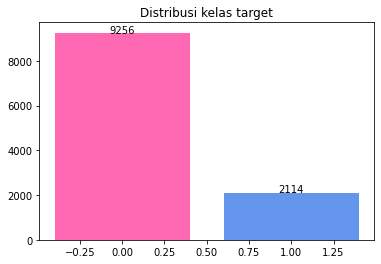

In [4]:
# Menghitung jumlah masing-masing target
target = list(set(data['target']))
jumlah_target = []
for i in target:
  jumlah_target.append(list(data['target']).count(i))

#visualisasi jumlah keyword
warna = np.array(['hotpink', 'cornflowerblue'])
plt.bar(target, jumlah_target, color=warna)
plt.title("Distribusi kelas target")
## Menampilkan label pada grafik
for i in range(len(target)):
    plt.text(i, jumlah_target[i], jumlah_target[i], ha = 'center')

plt.show()

In [5]:
#preprocessing
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text

data['text'] = data.apply(preprocess_tweet, axis=1)

In [6]:
def preprocess_data(data):
  #menghapus angka
  data = data.astype(str).str.replace('\d+', '', regex=True)
  #menjadikan lowercase
  lower_text = data.str.lower()
  #lemmatize
  lemmatizer = nltk.stem.WordNetLemmatizer()
  #tokenize
  w_tokenizer =  TweetTokenizer()

  def lemmatize_text(text):
      return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
  def remove_punctuation(words):
      new_words = []
      for word in words:
          new_word = re.sub(r'[^\w\s]', '', (word))
          if new_word != '':
            new_words.append(new_word)
      return new_words

  words = lower_text.apply(lemmatize_text)
  words = words.apply(remove_punctuation)
  return pd.DataFrame(words)

data['text'] = preprocess_data(data['text'])

In [7]:
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: [item for item in x if item not in stop_words])

In [8]:
#join tokenize data
data['text'] = data['text'].apply(lambda x: ' '.join(x))
data

,id,keyword,location,text,target
0,0,ablaze,NaN,communal violence bhainsa telangana stone pelt...,1
1,1,ablaze,NaN,telangana section ha imposed bhainsa january c...,1
2,2,ablaze,New York City,arsonist set car ablaze dealership,1
3,3,ablaze,"Morgantown, WV",arsonist set car ablaze dealership,1
4,4,ablaze,NaN,lord jesus love brings freedom pardon fill hol...,0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,medium warned u well advance wrecked whole nig...,0
11366,11366,wrecked,arohaonces,feel directly attacked consider moonbin jinjin...,0
11367,11367,wrecked,🇵🇭,feel directly attacked consider moonbin jinjin...,0
11368,11368,wrecked,auroraborealis,ok remember outcast nd dora au au wrecked nerv...,0


In [9]:
teks = np.array(data['text'])

#One hot encoding pada data target
target = np.array(pd.get_dummies(data['target']))

# Pemisahan data training & data testing
data_train,data_test,label_train,label_test = train_test_split(teks, target, test_size=0.2,
                                                               stratify=target, random_state=7)

In [10]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('cross-encoder/ms-marco-TinyBERT-L-2-v2')
bert_model = TFBertModel.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2", trainable=False, from_pt=True)

In [12]:
# Pendefinisian fungsi untuk melakukan tokenisasi pada satu data
def tokenisasi(teks):
      encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 80,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

      tokenID = encode_dict['input_ids']
      attention_mask = encode_dict['attention_mask']

      return tokenID, attention_mask

# Pendefinisian fungsi untuk mengambil hasil tokenisasi pada semua data
def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return {'input_ids': np.asarray(tokenID, dtype=np.int32).reshape(-1, 80), 
            'attention_mask': np.asarray(input_mask, dtype=np.int32).reshape(-1, 80)}

In [13]:
# Membuat tokenID untuk X_train dan X_test
X_train = create_input(data_train)
X_test = create_input(data_test)

#Mengambil representasi teks dari encoder layer ke 12 BERT
X_train = bert_model(**X_train)[0]
X_test = bert_model(**X_test)[0]

In [14]:
pip install -q -U keras-tuner

In [15]:
from keras_tuner.tuners import BayesianOptimization

In [16]:
#Mendefinisikan fungsi untuk klasifikasi dengan model hybrid CNN-LSTM menggunakan beberapa kandidat hyperparameter
def cnn_gru(hp):
    #Input layer
    input = keras.layers.Input(shape=(80, 128))

    #Convolution layer
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.01, 0.001])))(input)

    #Max Pooling layer
    maxpool = keras.layers.MaxPooling1D(pool_size=2)(cnn)

    #LSTM layer
    lstm = keras.layers.LSTM(units = hp.Int('units',
                                             min_value = 100,
                                             max_value = 200,
                                             step = 50),
                             kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                values = [0.01, 0.001])),
                             recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                   values = [0.01, 0.001])))(maxpool)
    #Output layer
    output = keras.layers.Dense(2, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(lstm)
    model = keras.models.Model(inputs=input, outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(1e-3),
                  loss ='categorical_crossentropy',
                  metrics=['accuracy'])
   
    return model

# Pendefinisian Callback
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Hyperparameter tuning menggunakan bayesian optimization
tuner = BayesianOptimization(cnn_gru,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = '/content/Hasil',
                             project_name = 'CNN-GRU',
                             overwrite = True)

tuner.search(X_train, label_train,
             batch_size=32, epochs=50,
             validation_split=0.2,
             callbacks=[early_stop, ClearTrainingOutput()])

# Mendapatkan model terbaik
model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.8730769157409668

Best val_accuracy So Far: 0.8730769157409668
Total elapsed time: 00h 07m 41s
INFO:tensorflow:Oracle triggered exit


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 128)]         0         
                                                                 
 conv1d (Conv1D)             (None, 77, 300)           153900    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 300)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 555,102
Trainable params: 555,102
Non-trainable params: 0
_______________________________________________________

In [21]:
# Retrain model pada data test
history = model.fit(X_train, label_train,
                    batch_size=64, epochs=50,
                    validation_data=(X_test, label_test),
                    callbacks=[early_stop])

Epoch 1/50
143/143 [==============================] - 2s 11ms/step - loss: 0.2855 - accuracy: 0.8994 - val_loss: 0.3564 - val_accuracy: 0.8738
Epoch 2/50
143/143 [==============================] - 1s 10ms/step - loss: 0.2882 - accuracy: 0.8973 - val_loss: 0.3533 - val_accuracy: 0.8760
Epoch 3/50
143/143 [==============================] - 1s 10ms/step - loss: 0.2834 - accuracy: 0.9001 - val_loss: 0.3405 - val_accuracy: 0.8738
Epoch 4/50
143/143 [==============================] - 2s 11ms/step - loss: 0.2812 - accuracy: 0.9022 - val_loss: 0.3613 - val_accuracy: 0.8619
Epoch 5/50
143/143 [==============================] - 1s 10ms/step - loss: 0.2781 - accuracy: 0.9077 - val_loss: 0.3521 - val_accuracy: 0.8676
Epoch 6/50
143/143 [==============================] - 1s 10ms/step - loss: 0.2756 - accuracy: 0.9051 - val_loss: 0.3479 - val_accuracy: 0.8685
Epoch 7/50
143/143 [==============================] - 1s 10ms/step - loss: 0.2689 - accuracy: 0.9079 - val_loss: 0.3388 - val_accuracy: 0.8760

In [22]:
# Mendapatkan kinerja model
y_pred = np.argmax(model.predict(X_test), axis=1)
y = np.argmax(label_test, axis=1)
print('accuracy: ', accuracy_score(y, y_pred),
      '\nprecicion: ', precision_score(y, y_pred),
      '\nrecall: ', recall_score(y, y_pred))

accuracy:  0.8715919085312225 
precicion:  0.6675191815856778 
recall:  0.6170212765957447


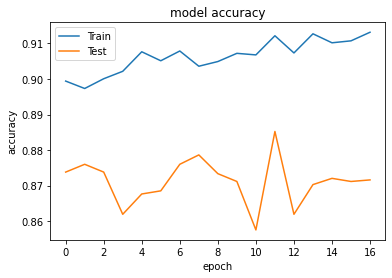

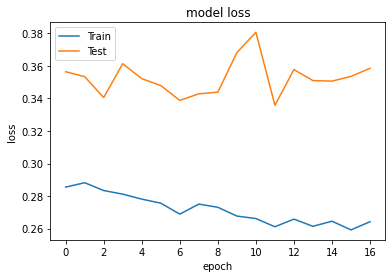

In [23]:
# plot grafik akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# plot grafik loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()